# Lab 8 Report: 
## FINAL PROJECT STRATEGIC PLANNING

### Lab 8 Instruction: 
https://canvas.uw.edu/files/106242897/download?download_frd=1

### Team Members:

### Dataset for your project:

#### Feel free to delete or modify pre-written markdown cells below the line

We first want to import stuff

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
from IPython.display import Image
sns.set(style = 'white', font_scale = 2)


In [2]:
torch.cuda.is_available()

True

## Understanding the Data

In [3]:
emotions = pd.read_csv('Neuros2_emotions.csv')
emotions_np = emotions.to_numpy()
emotions_np.shape

(2132, 2549)

In [4]:
emotions_np[:, -1]
target_data = []
for i in emotions_np[:, -1]:
    if i == "NEGATIVE":
        target_data.append(-1)
    if i == "NEUTRAL":
        target_data.append(0)
    if i == "POSITIVE":
        target_data.append(1)
        
target_data = np.array(target_data)
feature_data = emotions_np[:, :-1]
feature_data.shape


(2132, 2548)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_data = scaler.fit_transform(feature_data)


The main problem is creating a manageable set of attributes to use as inputs for our model.

I will first implement OneR as an example of what this might look like.

## Understanding the Task

In [6]:
from scipy.stats import norm
import bisect
def discretize(arry, num):
    probs = []
    for i in range(1,num):
        probs.append(norm.ppf(i/num))
    discretized_arry = []
    for i in arry:
        discretized_arry.append(bisect.bisect(probs, i) + 1)
    return np.array(discretized_arry)


def OneR(att, target, num):
    '''att is list of attributes, target is targets, num is number of bins'''
    
    cats = 3
    disc = discretize(att, num)
    result = np.zeros((num, cats))
    for i in range(att.shape[0]):
        result[disc[i]-1, target[i] + 1] += 1
    
    correct = 0
    for i in range(num):
        correct += max(result[i, :])
    return correct/att.shape[0]
    
accuracies = []
num = 4

for i in range(feature_data.shape[1]):
    accuracies.append(OneR(feature_data[:, i], target_data, num))


In [7]:
indices = np.argpartition(accuracies, -20)[-20:]
largest_20 = []
for i in indices:
    largest_20.append(accuracies[i])
largest_20

[0.6772983114446529,
 0.6777673545966229,
 0.6796435272045028,
 0.6801125703564728,
 0.6805816135084428,
 0.6801125703564728,
 0.6810506566604128,
 0.6810506566604128,
 0.6815196998123827,
 0.6815196998123827,
 0.6876172607879925,
 0.7195121951219512,
 0.6871482176360225,
 0.6829268292682927,
 0.7185741088180112,
 0.6899624765478424,
 0.7589118198874296,
 0.7593808630393997,
 0.6819887429643527,
 0.6885553470919324]

In [8]:
## Ok. Once we get that, we try to implement simple machine learning with those rows.

selected_feature_data = feature_data[:, indices]
selected_feature_data.shape

(2132, 20)

In [9]:
target_data = target_data + 1

In [10]:
target_data

array([0, 1, 2, ..., 0, 0, 1])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_feature_data, target_data, 
                                                    test_size=0.2, 
                                                    random_state=2)
X_validation = X_train[:int(len(X_test))]
y_validation = y_train[:int(len(X_test))]

X_train = X_train[int(len(X_test)):]
y_train = y_train[int(len(X_test)):]

In [12]:
class EmotionClassificationFCN(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden1_dim, hidden2_dim):# Add parameters for dimensions of 2 hidden layers 
        
        super(EmotionClassificationFCN, self).__init__()
        
        self.layer1 = torch.nn.Linear(input_dim, hidden1_dim)    # Connections from input to hidden layer 1
        self.layer2 = torch.nn.Linear(hidden1_dim, hidden2_dim)  # Connections from hidden layer 1 to hidden layer 2
        self.layer3 = torch.nn.Linear(hidden2_dim, output_dim)   # Connections from hidden layer 2 to final output
        
    def forward(self, x):
        
        out1 = torch.nn.functional.relu(self.layer1(x))          # Apply relu activation to layer 1 output
        out2 = torch.nn.functional.relu(self.layer2(out1))       # Apply relu activation to layer 2 output
        output = self.layer3(out2)                               # Return raw layer 3 output
        
        return output

In [43]:
model = EmotionClassificationFCN(input_dim = 20, output_dim = 3, hidden1_dim = 10, hidden2_dim = 10)

# Define the learning rate and epoch
learning_rate = 0.025
epochs = 200

# Define loss function (CrossEntropyLoss) and optimizer (Adam)
loss_func = torch.nn.CrossEntropyLoss() # Using cross entropy loss since we are outputing probabilities
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # Using Adam for more effective optimization

model

EmotionClassificationFCN(
  (layer1): Linear(in_features=20, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=3, bias=True)
)

In [44]:
## model.cuda()

In [45]:
train_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

In [46]:
import tqdm # For keeping track of our training progress in percentage

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors

train_inputs = torch.from_numpy(X_train).float()
train_targets = torch.from_numpy(y_train).long() # Convert to 64-bit integer

validation_inputs = torch.from_numpy(X_validation).float()
validation_targets = torch.from_numpy(y_validation).long()

testing_inputs = torch.from_numpy(X_test).float()
testing_targets = torch.from_numpy(y_test).long()

In [47]:
np.random.seed(45)
for epoch in tqdm.trange(epochs):
    
    optimizer.zero_grad()
    
    train_outputs = model(train_inputs)
    
    loss = loss_func(train_outputs, train_targets)
    
    train_loss_list[epoch] = loss.item()
    
    loss.backward()
    
    optimizer.step()
    
    # Compute Validation Accuracy ----------------------------------------------------------------------
    
    with torch.no_grad():
        
        validation_outputs = model(validation_inputs)    
        correct = (torch.argmax(validation_outputs, dim=1) == 
                   validation_targets).type(torch.FloatTensor)
        
        validation_accuracy_list[epoch] = correct.mean()

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 338.83it/s]


## Developing an initial plan for your project

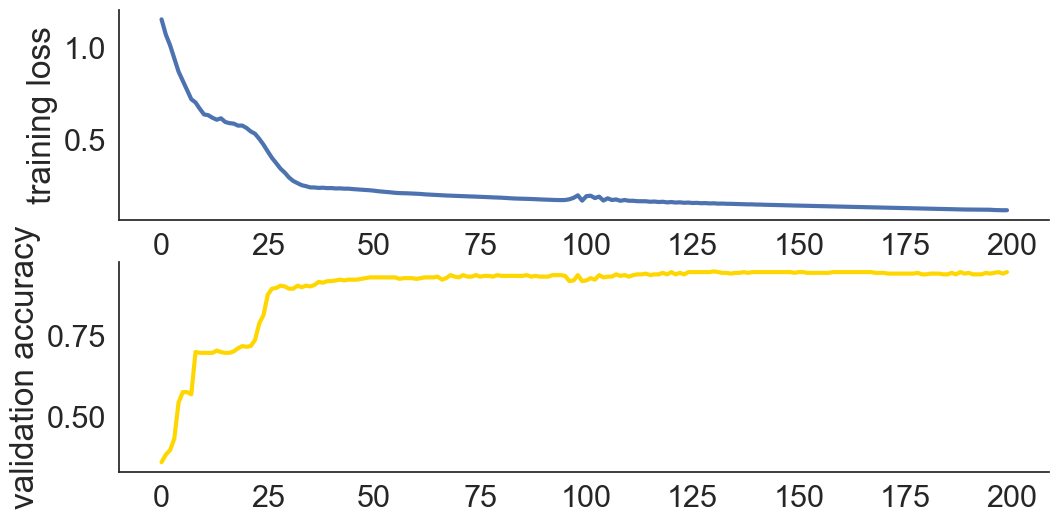

In [48]:
plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [49]:
with torch.no_grad():
    
    # Pass the testing feature data (30 samples) to the network to produce model predictions
    y_pred_test = model(testing_inputs) 
    
    # Use the same technique as above to commpute the testing classification accuracy
    correct = (torch.argmax(y_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    
    print("Testing Accuracy: " + str(correct.mean().numpy()*100) + '%')

Testing Accuracy: 94.61358189582825%


In [50]:
print(validation_accuracy_list)

[0.35831383 0.38173303 0.39578456 0.43091336 0.54332554 0.57611239
 0.57611239 0.56908667 0.70023417 0.69789225 0.69789225 0.69789225
 0.69789225 0.70491803 0.70023417 0.69789225 0.69789225 0.7025761
 0.71194381 0.71896958 0.71662766 0.71896958 0.73770493 0.78922719
 0.81498832 0.87822014 0.89695549 0.89929742 0.90632319 0.90398127
 0.89695549 0.89695549 0.90632319 0.90163934 0.90632319 0.90398127
 0.90866512 0.91803277 0.91569084 0.92037469 0.92037469 0.92271662
 0.92505854 0.92271662 0.92505854 0.92505854 0.92505854 0.92740047
 0.9297424  0.93208432 0.93208432 0.93208432 0.93208432 0.93208432
 0.93208432 0.93208432 0.92740047 0.9297424  0.9297424  0.9297424
 0.92740047 0.9297424  0.93208432 0.93208432 0.93208432 0.93442625
 0.92505854 0.9297424  0.93911004 0.93442625 0.93208432 0.93911004
 0.93442625 0.93442625 0.93911004 0.93442625 0.93676817 0.93676817
 0.93442625 0.93911004 0.93676817 0.93676817 0.93676817 0.93676817
 0.93676817 0.93676817 0.93911004 0.93442625 0.93676817 0.934426